## TFRecords and tf.Data
In this lab you will get familiar with TFrecords and the Tensorflow components used to read/write data to/from `.tfrecord` format. You will also get familiar with the `tf.data` API and learn how to read and deserialize TFRecords using it.

Learning Objectives:
* Learn how to use `tf.train.Example` and `tf.train.Feature`
* Learn how to coerce data into `tf.train.Feature` messages with `tf.train.BytesList`, `tf.train.FloatList` and `tf.train.Int64List`.
* Learn how write data to `.tfrecord` format with `tf.io.TFRecordWriter`
* Learn how to use the `tf.data` API to read and parse data from `.tfrecord` format

#### Setup

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

#### Getting Started
Essentially, a `tf.train.Example` is a `{"string": tf.train.Feature}` mapping. A `tf.train.Feature` can accept one of the following three types
* `tf.train.BytesList`. Used for string or bytes data
* `tf.train.FloatList`. Used for float32 or float64 data
* `tf.train.Int64List`. Used for bool, enum, int32, uint32, int64, or uint64 data

#### Create a `tf.train.Example` with sample data
Imagine your dataset has 3 features. 
* `x`: An integer feature
* `y`: A float feature
* `z`: A string feature
* `label`: An integer label 

In [2]:
# One example of this sample dataset
sample = {"x": 1, "y": 1.1, "z": "Blue", "label": 0}

In [3]:
# Create a tf.train.Example from the sample
example = tf.train.Example(
    features=tf.train.Features(
        feature={
            "x": tf.train.Feature(
                int64_list=tf.train.Int64List(value=[sample["x"]])
            ),
            "y": tf.train.Feature(
                float_list=tf.train.FloatList(value=[sample["y"]])
            ),
            "z": tf.train.Feature(
                bytes_list=tf.train.BytesList(
                    value=[sample["z"].encode("utf-8")]
                )
            ),
            "label": tf.train.Feature(
                int64_list=tf.train.Int64List(value=[sample["label"]])
            ),
        }
    )
)

In [4]:
example

features {
  feature {
    key: "label"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "x"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "y"
    value {
      float_list {
        value: 1.100000023841858
      }
    }
  }
  feature {
    key: "z"
    value {
      bytes_list {
        value: "Blue"
      }
    }
  }
}

#### Helper Functions
While it is possible to create `tf.train.Example` messages like above, it can be useful to use helper functions for coercing standard Python data types to `tf.train.Int64List`, `tf.train.FloatList`, or `tf.train.BytesList`.

Define these helper function and a `create_example` function to do what was manually done above.

In [5]:
# Helper functions
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

#### Function to create an Example

In [6]:
def create_example(sample):
    feature = {
        "x": _int64_feature(sample["x"]),
        "y": _float_feature(sample["y"]),
        "z": _bytes_feature(sample["z"].encode("utf-8")),
        "label": _int64_feature(sample["label"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [7]:
example = create_example(sample)
example

features {
  feature {
    key: "label"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "x"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "y"
    value {
      float_list {
        value: 1.100000023841858
      }
    }
  }
  feature {
    key: "z"
    value {
      bytes_list {
        value: "Blue"
      }
    }
  }
}

#### Serialize to String
There is a method to serialize `tf.train.Example` to a string. Remember, a TFRecord is simply a sequence of binary records. Serialize this example with `.SerializeToString()`, and then and deserialize with `tf.train.Example.FromString()` 

In [8]:
# Serialize example to bytestring
serialized_example = example.SerializeToString()
serialized_example

b'\n:\n\r\n\x01y\x12\x08\x12\x06\n\x04\xcd\xcc\x8c?\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x00\n\n\n\x01x\x12\x05\x1a\x03\n\x01\x01\n\r\n\x01z\x12\x08\n\x06\n\x04Blue'

In [9]:
# Recover example proto from serialized example
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "label"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "x"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "y"
    value {
      float_list {
        value: 1.100000023841858
      }
    }
  }
  feature {
    key: "z"
    value {
      bytes_list {
        value: "Blue"
      }
    }
  }
}

#### Writing Serialized Examples to TFRecords
You can write these serialized examples to `.tfrecord` format with `tf.io.TFRecordWriter`. Take a few samples and write them to one `.tfrecord` file. 

In [10]:
samples = [
    {"x": 1, "y": 1.1, "z": "Blue", "label": 0},
    {"x": 4, "y": 9.9, "z": "Red", "label": 1},
    {"x": 1, "y": 4.1, "z": "Green", "label": 1},
    {"x": 3, "y": 5.6, "z": "Blue", "label": 0},
]

In [11]:
with tf.io.TFRecordWriter("samples.tfrecord") as writer:
    for sample in samples:
        example = create_example(sample)
        writer.write(example.SerializeToString())

#### Reading TFRecords with the tf.data API
Now that you have created `samples.tfrecord` we need a way to ingest and use this data. For this we will use the `tf.data` API. The `tf.data` API enables you to build input pipelines that can handle large amounts of data, read from different data formats (both in-memory and out-of-memory), and perform complex transformations.

The `tf.data` API uses a `tf.data.Dataset` abstraction that represents a sequence of elements, in which each element consists of one or more components. To create an input pipeline you must start by constructing a `Dataset` with a data source. If your input data is stored in a file in the recommended TFRecord format, you can use the `tf.data.TFRecordDataset` to construct a dataset from a list of `.tfrecord` files.

Once you have a `Dataset` object, you can transform it into a new `Dataset` by chaining method calls on the `tf.data.Dataset`. For example, you can apply a per-element transformation (such as parsing a serialized Example) with `Dataset.map()`.

In the cells below:
* Create a `Dataset` from a list of `.tfrecord` files with `tf.data.TFRecordDataset`  
* Create a `parse_example` function to parse each Example in dataset
* Use `Dataset.map` to apply `parse_example` per-element

In [12]:
# Construct the tf.data Dataset
ds = tf.data.TFRecordDataset(["samples.tfrecord"])

2022-06-09 13:54:33.260962: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
# Take and print one example proto from the dataset
for record in ds.take(1):
    print(record)

tf.Tensor(b'\n:\n\n\n\x01x\x12\x05\x1a\x03\n\x01\x01\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x00\n\r\n\x01z\x12\x08\n\x06\n\x04Blue\n\r\n\x01y\x12\x08\x12\x06\n\x04\xcd\xcc\x8c?', shape=(), dtype=string)


2022-06-09 13:54:36.003694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


As you can see, the example is still serialized. We need to create a parsing function to map to this dataset. Remember that this parsing function will be applied per-element to the `Dataset`. In other words, this function is used to parse an individual `Example`. To do this, use `tf.io.parse_single_example(serialized, features)` which takes inputs:
* serialized: A scalar string Tensor, a single serialized Example
* features: a dict mapping feature keys to `tf.io.FixedLenFeature` or `tf.io.VarLenFeature` values

In [14]:
def parse_example(example_proto):

    # Create a description of the features.
    feature_description = {
        "x": tf.io.FixedLenFeature([], tf.int64),
        "y": tf.io.FixedLenFeature([], tf.float32),
        "z": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }

    # Parse the input `tf.train.Example` proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, feature_description)

In [15]:
# Map parsing function to the dataset
ds = ds.map(parse_example)

In [16]:
# Take one example from the dataset and print it out
for record in ds.take(1):
    for key, value in record.items():
        print(
            f"name: {key} | dtype: {value.dtype} | shape: {value.shape} | value: {value.numpy()}"
        )

name: label | dtype: <dtype: 'int64'> | shape: () | value: 0
name: x | dtype: <dtype: 'int64'> | shape: () | value: 1
name: y | dtype: <dtype: 'float32'> | shape: () | value: 1.100000023841858
name: z | dtype: <dtype: 'string'> | shape: () | value: b'Blue'


#### Creating TFRecords for Image Data
Creating TFRecords for image data is a similar process to what you've just done for sample structured data. The difference is that with image data, we need to encode the image as a bytestring. Once the image is a bytestring, we can use `tf.train.BytesList` the same as above. In this lab we will work with some publically available images in GCS. The steps will be:
* Define functions to create examples from image data
* Write example protos to `.tfrecord` format
* Use tf.data API to ingest and parse the data
* Validate

In [17]:
# 4 examples of data for an image classification use case
data = [
    {
        "image_uri": "gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg",
        "label": "dandelion",
    },
    {
        "image_uri": "gs://cloud-ml-data/img/flower_photos/sunflowers/4933229095_f7e4218b28.jpg",
        "label": "sunflowers",
    },
    {
        "image_uri": "gs://cloud-ml-data/img/flower_photos/tulips/8713398906_28e59a225a_n.jpg",
        "label": "tulips",
    },
    {
        "image_uri": "gs://cloud-ml-data/img/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg",
        "label": "daisy",
    },
]

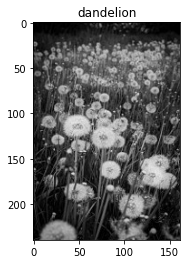

In [18]:
# Take a single example and plot with label
single_example = data[0]
img = tf.io.decode_jpeg(tf.io.read_file(single_example["image_uri"]))
plt.imshow(img)
plt.title(single_example["label"])
plt.show()

#### Image helper function
The plan is to use `tf.train.BytesList` for our images. To do this we can create a helper function. This helper function will look similar to our other helper functions. However instead of simply passing a scalar value to a `tf.train.Feature` compatible list, it will encode the image data with `tf.io.encode_jpeg`, which returns a Tensor of type string.

In [19]:
def _image_feature(image):
    """Returns a bytes-list from an image"""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])
    )

Function to create an example for image data

In [20]:
def create_img_example(image, label):
    feature = {
        "image": _image_feature(image),
        "label": _bytes_feature(label.encode("utf-8")),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

The `_image_feature` helper function used in `create_img_example` uses `tf.io.encode_jpeg`. This expects a Tensor of type uint8. 3-D with shape [height, width, channels]. This means that we need to read the images from the URIs in the dataset and decode the data to that specification. For this we can use `tf.io.read_file` and `tf.io.decode_jpeg` to read and decode each image before passing to `create_example`.

Write the images out to `.tfrecord` format.

In [21]:
with tf.io.TFRecordWriter("imagedata.tfrecord") as writer:
    for sample in data:
        image = tf.io.decode_jpeg(tf.io.read_file(sample["image_uri"]))
        label = sample["label"]
        example = create_img_example(image, label)
        writer.write(example.SerializeToString())

#### Ingest, Parse, and Read image data with tf.data
We can use `tf.data.TFRecordDataset` to create a dataset from a list of `.tfrecord` files. The parsing function for a single `Example` will again use a feature description and `tf.io.parse_single_example`. We will also include a `tf.io.decode_jpeg` to decode the jpeg-encoded image to a uint8 tensor.

In [22]:
ds = tf.data.TFRecordDataset(["imagedata.tfrecord"])

In [23]:
def parse_img_example(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

In [24]:
ds = ds.map(parse_img_example)

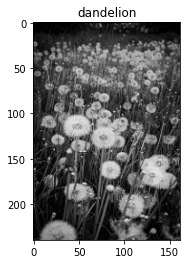

In [25]:
for record in ds.take(1):
    plt.imshow(record["image"].numpy())
    plt.title(record["label"].numpy().decode())
    plt.show()

Clean up

In [26]:
!rm samples.tfrecord
!rm imagedata.tfrecord

Congrats! In this lab you learned about writing data to `.tfrecord` format by structuring your data with `tf.train.Example`, and reading/parsing data in `.tfrecord` format with `tf.data`.